Import Libraries

Loads essential libraries for data processing, visualization, machine learning (SVM, neural networks), and ECG signal processing.

In [2]:
import os
import sys
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from biosppy.signals import ecg
from sklearn import metrics
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F

d:\Programming\Python\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Set Up File Paths & Labels

Ignores warnings, sets the filepath for ECG data, loads diagnosis labels, and initializes empty arrays for signals and labels.

In [100]:
warnings.simplefilter(action='ignore', category=FutureWarning)

# Set filepath
filepath = 'PTB_processed_new'
total = len(os.listdir(filepath))

# Load label file
labels_file = pd.read_csv("new_labels.csv", header=0)
labels = np.asarray(labels_file['diagnosis'])

# Create empty containers
signal_array = []  # To store all segments
label_array = []   # To store all labels

# Create counters
files_completed = 0
file_number = 0

Extract ECG Signal Segments

Iterates through ECG files, detects peaks using the biosppy library, extracts segments, and stores them with corresponding labels.

In [101]:
# Signal Extractor
start_time = time.time()
for filename in os.listdir(filepath):
    start_time_file = time.time()
    data = pd.read_csv(os.path.join(filepath, filename), header=0, engine='python')
    file_label = labels[file_number]
    col_names = ['v1', 'v2', 'v3', 'v4', 'v5', 'v6'] # Columns used

    # Compute peaks based on V4 (or alternatively, use an averaged signal)
    peaks = ecg.christov_segmenter(np.array(data['v4']), 1000)[0]

    for peak in range(1, len(peaks) - 1):
        segment_array = []  # To store one segment

        # Extract segment for each column
        for col in data: # Replace data with col_names to only use specific columns
            segment = np.array(data[col])[peaks[peak] - 50:peaks[peak] + 100]  # Extract segment
            segment_array.append(segment)

        signal_array.append(segment_array)
        label_array.append(file_label)

    files_completed += 1
    file_number += 1
    progress = round(files_completed / total * 100, 2)
    end_time_file = time.time()
    elapsed_time_file = round(end_time_file - start_time_file, 2)
    sys.stdout.write(f'\r{filename} loaded - {progress}% completed - Took: {elapsed_time_file} seconds')


signal_array = np.asarray(signal_array)
end_time = time.time()
elapsed_time = round(end_time - start_time, 2)
print(f'\nData loading completed: {files_completed} files - Took: {elapsed_time} seconds')

le = preprocessing.LabelEncoder()
data_labels = le.fit_transform(label_array)
num_classes = le.classes_.size
print(le.classes_)
print(f'Number of classes: {num_classes}')
print(f'{len(label_array)} Labels loaded')

record513_patient294_Myocardial infarction.csv loaded - 100.0% completed - Took: 0.96 secondss
Data loading completed: 513 files - Took: 255.34 seconds
['Bundle branch block' 'Cardiomyopathy' 'Dysrhythmia' 'Healthy control'
 'Hypertrophy' 'Myocardial infarction' 'Myocarditis'
 'Valvular heart disease']
Number of classes: 8
8996 Labels loaded


Preprocess Data & Convert to Tensors

Splits data into training and test sets, reshapes and imputes missing values, and converts them into PyTorch tensors.

In [102]:
# Split the dataset into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(signal_array, data_labels, test_size=0.3, random_state=7)

# Flatten the data to convert each sample to a single feature vector
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Impute missing values using the mean
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Convert data to PyTorch tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.long).to(device)

Define Neural Network & Loss Function

Implements an MLP model with multiple layers, ReLU activations, dropout, and a classifier. Also defines Focal Loss to handle class imbalance.Computes class weights, initializes the model, optimizer, and training loop for 250 epochs, tracking loss and accuracy.

In [164]:
# Neural Network
class MLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLP, self).__init__()
        # Feature extractor
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        # Final classifier layer
        self.classifier = nn.Linear(16, num_classes)

    def forward(self, x):
        features = self.feature_extractor(x)
        out = self.classifier(features)
        return out

    def extract_features(self, x):
        with torch.no_grad():
            return self.feature_extractor(x)


# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.alpha is not None:
            focal_loss *= self.alpha[targets]

        return focal_loss.mean()

# Class distribution
class_counts = torch.bincount(Y_train_tensor)

# Compute class weights (inverse frequency)
class_weights = 1.0 / class_counts.float()
class_weights = class_weights / class_weights.sum()

# Assign higher weight to Class 6
class_weights[6] *= 2.0

# Move weights to device (GPU/CPU)
class_weights = class_weights.to(device)

# Initialize Focal Loss with custom weights
criterion = FocalLoss(gamma=2.0, alpha=class_weights)

# Model Assignment
input_dim = X_train.shape[1]
model = MLP(input_dim, num_classes).to(device)

# Optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(model.parameters(), lr=0.003, weight_decay=1e-5)
no_of_epochs = 250

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(no_of_epochs):
    model.train()
    
    # Forward pass (Training)
    outputs = model(X_train_tensor)
    train_loss = criterion(outputs, Y_train_tensor)
    
    # Compute training accuracy
    _, train_preds = torch.max(outputs, 1)
    train_acc = (train_preds == Y_train_tensor).float().mean().item()
    
    # Backpropagation
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # Store training loss and accuracy
    train_losses.append(train_loss.item())
    train_accuracies.append(train_acc)

    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_loss = criterion(test_outputs, Y_test_tensor)
        
        # Compute test accuracy
        _, test_preds = torch.max(test_outputs, 1)
        test_acc = (test_preds == Y_test_tensor).float().mean().item()
        
        # Store test loss and accuracy
        test_losses.append(test_loss.item())
        test_accuracies.append(test_acc)

    # Print every 10 epochs
    if (epoch + 1) % 10 == 0:
        sys.stdout.write(f"\rEpoch [{epoch+1}/{no_of_epochs}], Train Loss: {train_loss.item():.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss.item():.4f}, Test Acc: {test_acc:.4f}")

# Switch to evaluation mode and extract features
model.eval()
with torch.no_grad():
    train_features = model.extract_features(X_train_tensor).cpu().numpy()
    test_features = model.extract_features(X_test_tensor).cpu().numpy()

Epoch [250/250], Train Loss: 0.0009, Train Acc: 0.9254, Test Loss: 0.0014, Test Acc: 0.9715

In [8]:
# Train an SVM classifier on the extracted features
svm = SVC(kernel='linear', probability=True)
svm.fit(X_train, Y_train)

# Make predictions with the SVM
y_pred_test = svm.predict(X_test)

In [165]:
# NN FEATURES
# Train an SVM classifier on the extracted features
svm_nn = SVC(kernel='linear', probability=True)
svm_nn.fit(train_features, Y_train)

# Make predictions with the SVM
y_pred_test_nn = svm_nn.predict(test_features)

Feature Extraction & Evaluation

Switches to evaluation mode, extracts learned features from the trained neural network, and stores them for further analysis.

In [10]:
def show_confusion_matrix(true_labels, predicted_labels):
    matrix = metrics.confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix, cmap='coolwarm', linecolor='white', linewidths=1,
                xticklabels=le.classes_, yticklabels=le.classes_, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

SVM WITHOUT NN


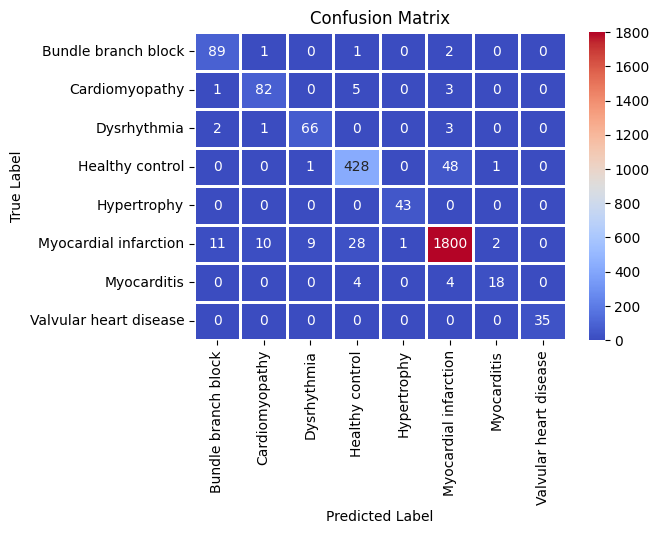

              precision    recall  f1-score   support

           0       0.86      0.96      0.91        93
           1       0.87      0.90      0.89        91
           2       0.87      0.92      0.89        72
           3       0.92      0.90      0.91       478
           4       0.98      1.00      0.99        43
           5       0.97      0.97      0.97      1861
           6       0.86      0.69      0.77        26
           7       1.00      1.00      1.00        35

    accuracy                           0.95      2699
   macro avg       0.92      0.92      0.91      2699
weighted avg       0.95      0.95      0.95      2699



In [11]:
print("SVM WITHOUT NN")
show_confusion_matrix(Y_test, y_pred_test)
print(classification_report(Y_test, y_pred_test))




SVM WITH NN


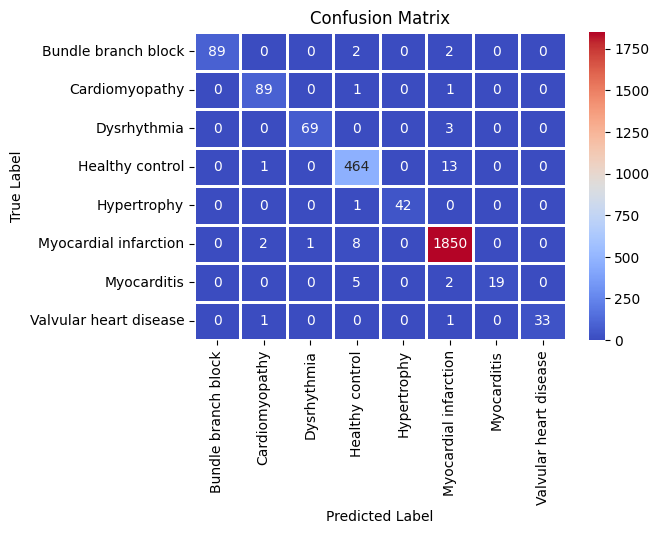

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        93
           1       0.96      0.98      0.97        91
           2       0.99      0.96      0.97        72
           3       0.96      0.97      0.97       478
           4       1.00      0.98      0.99        43
           5       0.99      0.99      0.99      1861
           6       1.00      0.73      0.84        26
           7       1.00      0.94      0.97        35

    accuracy                           0.98      2699
   macro avg       0.99      0.94      0.96      2699
weighted avg       0.98      0.98      0.98      2699



In [166]:
print("\n\nSVM WITH NN")
show_confusion_matrix(Y_test, y_pred_test_nn)
print(classification_report(Y_test, y_pred_test_nn))